<center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">به نام خدا</div></center>
<h1><center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">افزایش داده ها  (data augmentationata)</div></center></h1>

**[Image data preprocessing](https://keras.io/api/preprocessing/image/)**  
**[Data loading](https://keras.io/api/data_loading/)**  
**[Image classification](https://www.tensorflow.org/tutorials/images/classification)**  
**[Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)**

برای استفاده از این نوت بوک باید 


1.   اکانت سایت کگل داشته باشید
1.   از سایت کگل/API KEY را دریافت کنید که به صورت یک فایل json  است 
1.   این فایل را در ریشه گوگل درایو خود آپلود کنید
1.   و سپس کدهای زیر را اجرا کنید


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats -f train.zip
!mkdir catDog
!unzip 'train.zip' -d './catDog' > /dev/null

 99% 536M/543M [00:03<00:00, 200MB/s]
100% 543M/543M [00:03<00:00, 184MB/s]


In [72]:
import os,pathlib,glob,shutil
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

import PIL


<p style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"><strong>کاری که قرار است انجام شود به شرح ذیل است:</strong></p>


---


<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">



<ol>
<li>اول داده ها دانلود شوند: فایل داده به صورت یک فایل زیپ 543 مگابایتی است که یک فولدر Train داخل آن قرار دارد و حاوی 12500 تصویر گربه و 12500 تصویر سگ است</li>
<li>سپس فایلها در دو فولدر cat و dog تفکیک شوند : برای راحتی در مسیر دهی، از روش نسبی استفاده میکنیم و فایلها را در محلی که نوت بوک قرار دارد اکسترکت میکنیم. و با کد نویسی فایلهای مربوط به هر شاخه را داخل آن قرار میدهیم</li>
<li>سپس دیتا ست train و test را با کمک keras.preprocessing.image_dataset_from_directory <span>درست میکنیم. هر کدام از این دیتا ستها </span>&nbsp;&nbsp;از نوع <span>BatchDataset</span> هستند.</li>
<li>برای ایجاد آگمنتاسیون از لایه های پیش پردازش خود کراس/ تنسرفلو استفاده میکنیم. به این معنی که هر تغییری که میخواهیم اعمال کنیم در داخل مدل انجام میدهیم. این کار دو اثر دارد که باید سبک سنگین کرد:</li>
<ul>
<li>On-device اجرا میشود، به صورت synchronous <span>با بقیه لایه های مدل اجرا میشود و از قدرت </span>GPU بهره میگیرد.</li>
<li>وقتی که مدل را ذخیره میکنیم، این لایه های پیش پردازش هم در کنار بقیه مدل ذخیره میشوند.</li>
</ul>
<li>مدل را آموزش میدهیم : دقت کنیم که آگمنتاسیون فقط برای آموزش است و در test و &nbsp;eval <span>استفاده نمیشود</span></li>
<li>متریک مدل را به صورت نمودار نشان میدهیم</li>
<li>سرانجام یک داده را پیش بینی میکنیم</li>
</ol>
</div>

In [4]:
base_dir = pathlib.Path('./catDog/')
cat_dir= os.path.join(base_dir, 'cat')
dog_dir= os.path.join(base_dir, 'dog')

In [5]:
# create a folder for each class
os.mkdir(cat_dir)
os.mkdir(dog_dir)

catsfilenames= glob.glob("./catDog/train/cat*.jpg")
dogsfilenames= glob.glob("./catDog/train/dog*.jpg")

for fileName in catsfilenames[0:2000]:
    shutil.move(fileName,'./catDog/cat')

for fileName in dogsfilenames[0:2000]:
    shutil.move(fileName,'./catDog/dog')
shutil.rmtree('./catDog/train')

In [6]:
print('total cat images:', len(os.listdir(cat_dir)))
print('total dog images:', len(os.listdir(dog_dir)))
image_count = len(list(base_dir.glob('*/*.jpg')))
print(image_count)

total cat images: 2000
total dog images: 2000
4000


In [7]:
cat_images=list(base_dir.glob('cat/*'))

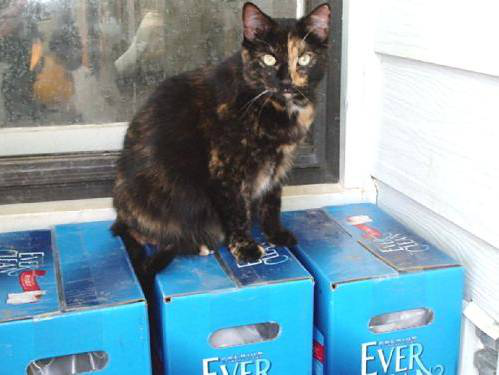

In [8]:
PIL.Image.open(str(cat_images[0]))

## Create TRAIN and VALIDATION datasets

In [9]:
train_ds=keras.preprocessing.image_dataset_from_directory(base_dir,seed=123,subset='training',validation_split=0.2)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.


In [10]:
val_ds=keras.preprocessing.image_dataset_from_directory(base_dir,seed=123,subset='validation',validation_split=0.2)

Found 4000 files belonging to 2 classes.
Using 800 files for validation.


In [11]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [12]:
len(train_ds) 

100

In [13]:
class_names=train_ds.class_names
class_names

['cat', 'dog']

In [14]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

## display first 9 images from the first batch:

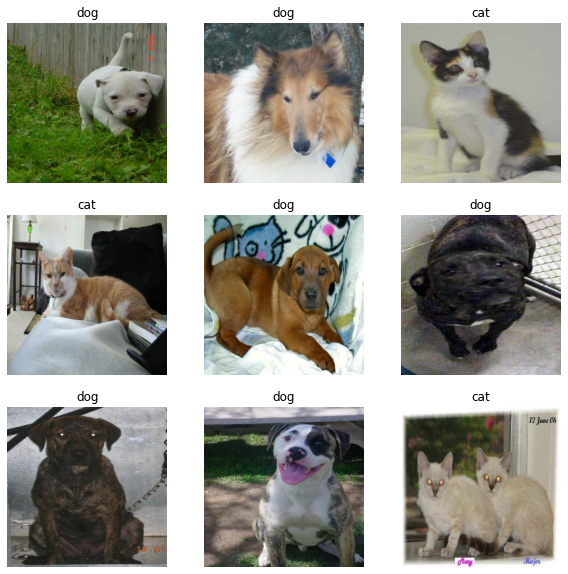

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## dataset Tuning

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model: inject augmentations to the model

In [74]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

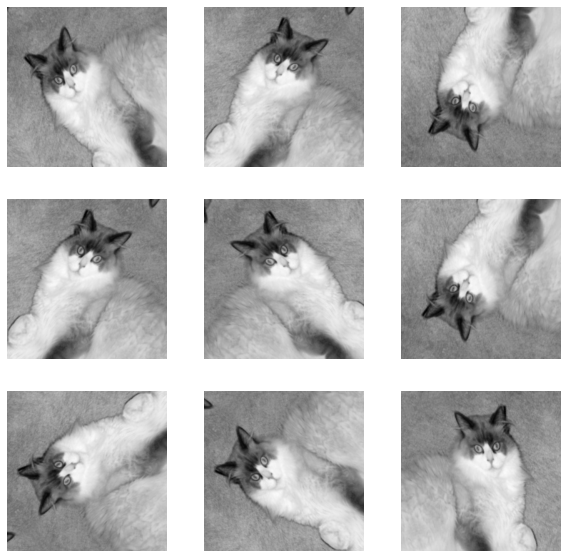

In [75]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [77]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(100, 100),
  layers.Rescaling(1./255)
])

In [89]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(64, activation='relu'),
  layers.Dense(1,activation ='sigmoid')
])

In [90]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [91]:
model.fit(train_ds.take(1),validation_data=val_ds.take(1),epochs=1)

1/1 [==============================] - 2s 2s/step - loss: 0.6782 - accuracy: 0.5938 - val_loss: 0.6624 - val_accuracy: 0.5938


In [92]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, None, None, 3)     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                 

# Training the model

In [93]:
epochs=10
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
100/100 [==============================] - 2s 25ms/step - loss: 0.6975 - accuracy: 0.5009 - val_loss: 0.6911 - val_accuracy: 0.5750
Epoch 2/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6942 - accuracy: 0.4963 - val_loss: 0.6914 - val_accuracy: 0.5938
Epoch 3/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6767 - accuracy: 0.5744 - val_loss: 0.6408 - val_accuracy: 0.6625
Epoch 4/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6500 - accuracy: 0.6263 - val_loss: 0.6228 - val_accuracy: 0.6388
Epoch 5/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6278 - accuracy: 0.6509 - val_loss: 0.5964 - val_accuracy: 0.6787
Epoch 6/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6112 - accuracy: 0.6628 - val_loss: 0.6032 - val_accuracy: 0.6837
Epoch 7/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6027 - accuracy: 0.6778 - val_loss: 0.5867 - val_accuracy: 0.6875

## Visualize training results

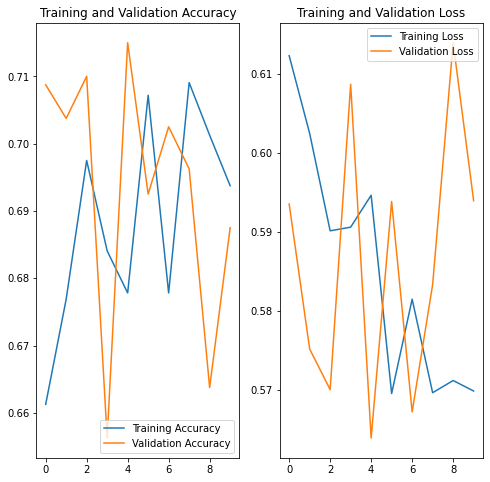

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict:

In [ ]:
!kaggle competitions download -c dogs-vs-cats -f test1.zip
!unzip 'test1.zip' -d '.' > /dev/null

This image most likely belongs to cat with a 59.69 percent confidence.


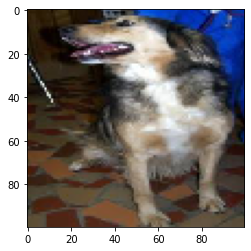

In [95]:
import numpy as np
filesList= glob.glob("./test1/*.jpg")
testfilepath= filesList[tf.random.uniform(shape=(), minval=0, maxval=12499, dtype=tf.dtypes.int32, seed=None, name=None).numpy()]

img = tf.keras.utils.load_img(testfilepath, target_size=(100, 100))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
plt.imshow(img)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

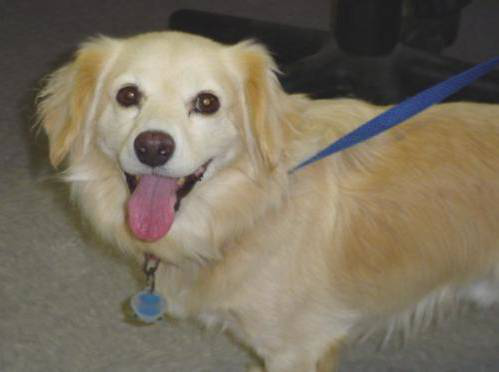

In [68]:
PIL.Image.open(testfilepath)